In [1]:
library(stringr)

In [2]:
suppressPackageStartupMessages(library(vioplot))

In [3]:
setwd('/nfs/lab/projects/pbmc_snATAC/analysis_v2/allele_freq')

In [4]:
vtested = read.table("../example_boxplots/All_tested_genotypes.tsv", header=T)

In [5]:
vlist = substring(rownames(vtested),4)

In [6]:
writeLines(vlist, "List_of_tested_variants")

In [ ]:
#gatsby
# plink \
# --bfile /nfs/lab/1KGP/1KGP_ALL.merged \
# --keep /nfs/lab/1KGP/1KGP.EUR.samples \
# --exclude /nfs/lab/1KGP/1KGP_ALL.merged.dupvars \
# --freq \
# --extract List_of_tested_variants 


In [109]:
traits = c( 'Asthma_child_onset.99credset.PPA.bed',
            'Atopic_dermatitis.99credset.PPA.bed',
            'Autoimmune_vitiligo.99credset.PPA.bed',
            'Basophil_count.99credset.PPA.bed',
            'Crohns_disease.99credset.PPA.bed',
            'Eosinophil_count.99credset.PPA.bed',
            'Gout.99credset.PPA.bed',
            'Lymphocyte_count.99credset.PPA.bed',
            'Monocyte_count.99credset.PPA.bed',
            'Neutrophil_count.99credset.PPA.bed',
            'Primary_sclerosing_cholangitis.99credset.PPA.bed',
            'Rheumatoid_arthritis.99credset.PPA.bed',
            'Selective_IgA_deficiency.99credset.PPA.bed',
            'Systemic_lupus_erythematosus.99credset.PPA.bed',
           'Type_1_diabetes.99credset.PPA.bed',
            'Ulcerative_colitis.99credset.PPA.bed')

In [110]:
fmdir = '/nfs/lab/projects/pbmc_snATAC/data/credible_sets/'

In [111]:
alltraits = data.frame()
for (i in 1: length(traits)){

fm = read.table(paste0(fmdir, traits[i] ))
colnames(fm) = c("chr", "start", "stop", "varID", "Locus", "LNBF", "PPA")
 fm$Trait =  str_split_fixed(traits[i], "\\.", 2)[,1]
 alltraits = rbind(alltraits, fm)
    }
    

In [112]:
fmlist = unique(alltraits$varID)

In [113]:
writeLines(fmlist, "List_of_finemapped_variants")

In [ ]:
#gatsby
# plink \
# --bfile /nfs/lab/1KGP/1KGP_ALL.merged \
# --keep /nfs/lab/1KGP/1KGP.EUR.samples \
# --exclude /nfs/lab/1KGP/1KGP_ALL.merged.dupvars \
# --freq \
# --extract List_of_finemapped_variants \
# --out finemapped

In [134]:
t1dss = read.table('t1d_vars')

t1dss$varID = with(t1dss, paste(V2,V3,V5,V4, sep=":"))

writeLines(t1dss$varID, "t1d_finemapped_variants")

In [ ]:
# plink \
# --bfile /nfs/lab/1KGP/1KGP_ALL.merged \
# --keep /nfs/lab/1KGP/1KGP.EUR.samples \
# --exclude /nfs/lab/1KGP/1KGP_ALL.merged.dupvars \
# --freq \
# --extract t1d_finemapped_variants \
# --out t1d_finemapped

In [145]:
nmli = setNames(t1dss$varID, nm = t1dss$V1)
alltraits$varID[alltraits$varID %in% names(nmli) ] <- nmli[alltraits$varID[alltraits$varID %in% names(nmli) ]]
sum(grepl ("rs", alltraits$varID))

In [156]:
fmlist = unique(alltraits$varID)

In [191]:
write.table(alltraits[,1:4], "finemapped_variants.bed", sep="\t", quote=F, row.names=F, col.names=F)

In [192]:
system( 'bedtools intersect -a finemapped_variants.bed -b /nfs/lab/projects/pbmc_snATAC/geo_submission/snATAC_merged_celltypes_peaks.bed -wa -wb > finemapped_variants_intersectpeaks.bed')

In [195]:
inpeaks = read.table('finemapped_variants_intersectpeaks.bed') 

In [197]:
fm_inpeaks = unique(inpeaks$V4)

In [198]:
length(vlist)
length(fmlist)
length(fm_inpeaks)
sum(vlist %in% fmlist)

[1] 191116

[1] 45911

[1] 4925

[1] 3655

In [ ]:
##  4925 out of 45911 variants in the 99% credible sets were in a PBMC peak
##  3655 out of these 4925 SNPs were tested in our snATAC

In [10]:
caqdir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/summarized_caqtls/run3/'
files  = list.files(caqdir)[grepl ('_caqtl_sumstats_run3.tsv', list.files(caqdir))] 
files = files[!(files %in% c('cd4_t_caqtl_sumstats_run3.tsv', 'cd8_t_caqtl_sumstats_run3.tsv', "bulk_caqtl_sumstats_run3.tsv"))]
cells  = gsub( '_caqtl_sumstats_run3.tsv', "" , files)

In [11]:
colkeep = c('Feature','varID', 'rsID', 'P_value', 'Q_value' ,'Effect_size' ,'cell', "exclude" )

In [12]:
M= data.frame()
for (y in 1:length(files)){

sms = read.table(paste0(caqdir, files[y]), header=T)
sss = subset(sms, Is_peak_caQTL==T )
sss = sss[order(sss$Q_value),]
ag  = aggregate(Q_value~Feature, sss, min)
mm  = merge (sss, ag, by= colnames(ag))
mm$cell = cells[y]
M    = rbind(M, mm[,colkeep])
}

In [13]:
### Lead variants: all variants with the min qvalue per feature

In [167]:
df = data.frame(tested = vlist, caQTl = paste0("chr", vlist) %in% M$varID , finemapped = vlist %in% fmlist  )

In [168]:
table(df$caQTl, df$finemapped)

       
         FALSE   TRUE
  FALSE 166615   3050
  TRUE   20846    605

In [169]:
fisher.test(table(df$caQTl, df$finemapped))


	Fisher's Exact Test for Count Data

data:  table(df$caQTl, df$finemapped)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.448874 1.732627
sample estimates:
odds ratio 
  1.585415 


In [170]:
af1 = read.table("plink.frq", header=T)

In [171]:
df = merge(df, af1, by.x="tested", by.y="SNP")

In [19]:
af2 = read.table("finemapped.frq", header=T)
af2 = rbind( af2, read.table("t1d_finemapped.frq", header=T))

In [175]:
af2 = af2[!duplicated(af2$SNP),]

In [176]:
aflist = list(af2$MAF, df$MAF, df$MAF[df$caQTl], df$MAF[df$finemapped], df$MAF[df$caQTl &df$finemapped])

In [177]:
names(aflist)<-c("finemapped", "tested QTL", "signif QTL", 
                                                      "tested & finemapped", "caQTL & finemapped")

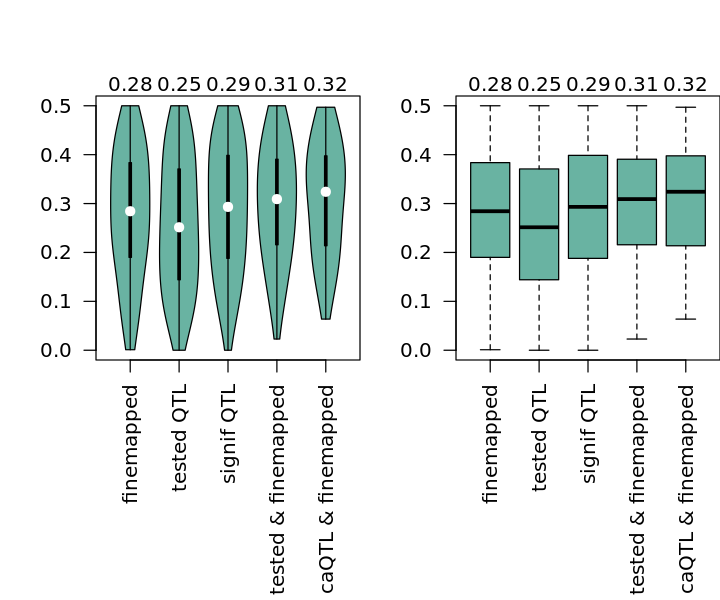

In [202]:
par(mfrow=c(1,2), mar = c(10,4,4,0))
vioplot(aflist, las=2, col="#69b3a2")
mtext(round(sapply(aflist, median),2), at =1:5)
boxplot(aflist, las=2, col="#69b3a2")
mtext(round(sapply(aflist, median),2), at =1:5)

In [179]:
round(sapply(aflist, median),2)

finemapped          tested QTL          signif QTL tested & finemapped 
               0.28                0.25                0.29                0.31 
 caQTL & finemapped 
               0.32

In [180]:
df$MAFgroup = cut(df$MAF, breaks = 5)

In [181]:
tb = table(df$MAFgroup, df$caQTl)

In [182]:
prp = t(tb)/colSums(tb)

In [184]:
colnames(prp)=c("0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5")

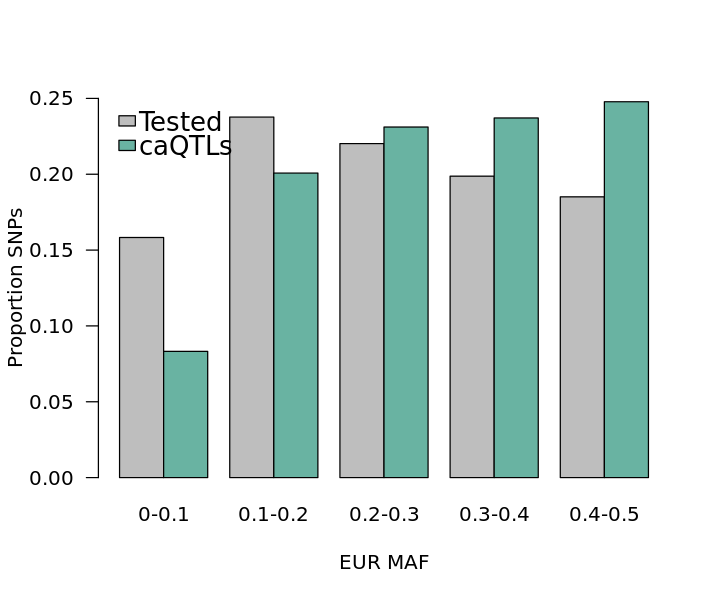

In [185]:
options(repr.plot.width=6, repr.plot.height=5)
barplot(prp, beside = T, col =c("gray", "#69b3a2"),las=1, space = c(0,0.5),
        ylim = c(0,0.25), ylab="Proportion SNPs", xlab="EUR MAF")
legend("topleft", fill = c("gray", "#69b3a2"), legend = c("Tested", "caQTLs"), bty="n", 
       cex=1.3,x.intersp = 0.2,y.intersp = 1.2)

In [186]:
dim(df)

[1] 189852      9

In [203]:
head(fm_inpeaks)

[1] "1:8526142:G:A" "1:8537289:G:A" "1:8556545:A:G" "1:8557320:C:G"
[5] "1:8557691:A:C" "1:8569871:A:T"

In [204]:
inP = subset(af2, SNP %in% fm_inpeaks)

In [211]:
inP$MAFgroup = cut(inP$MAF, breaks = c(0,0.1,0.2,0.3,0.4,0.5))

In [214]:
inP$tested  = inP$SNP %in% vlist

In [220]:
bp = t(table(inP$MAFgroup,inP$tested==FALSE))

In [233]:
getwd()

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/allele_freq"

In [237]:
pdf("../figures/allelefreq_finemapped.pdf")
par(pin = c(5,3))
pp<-barplot(bp, col =c("orange", "gray"),las=1, 
        ylim = c(0,1200), ylab="# finemapped SNPs in PBMC cCREs", xlab="EUR MAF")
legend("topleft", fill = c( "orange", "gray"), legend = c("Tested", "Not tested"), bty="n", 
       cex=1.3,x.intersp = 0.2,y.intersp = 1.2)
text(x=pp,y=bp[1,], labels = round(bp[1,]/colSums(bp),2), pos = 3)
dev.off()

png 
  2

In [228]:
round(bp[1,]/colSums(bp),2)

(0,0.1] (0.1,0.2] (0.2,0.3] (0.3,0.4] (0.4,0.5] 
     0.32      0.72      0.87      0.90      0.89

In [227]:
bp

       
        (0,0.1] (0.1,0.2] (0.2,0.3] (0.3,0.4] (0.4,0.5]
  FALSE     177       621       955      1051       848
  TRUE      373       238       137       121       106

In [29]:
longf = read.table('../summarized_caqtls/run3/EUR_caqtl_leads_run3.tsv', header=T)

longf$exclude = longf$Sequencing_mapping_error_rate>0.1 | longf$Ref_allele_bias<0.2 | longf$Ref_allele_bias>0.8


In [31]:
df$varID = paste0( "chr" , df$tested)

In [32]:
longf = merge(longf, df[,c ('varID','MAF')], by="varID")

In [33]:
longf= longf[order(longf$P_VAl),]

In [34]:
longfsub = subset(longf, !duplicated(longf$Feature))

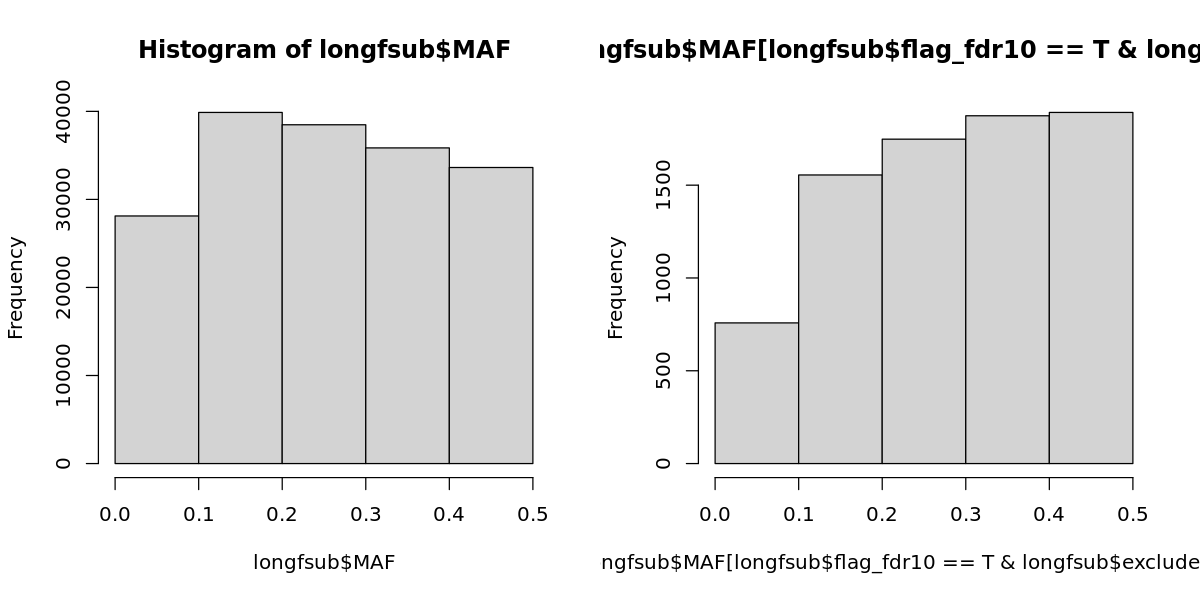

In [36]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
hist(longfsub$MAF, breaks=5)
hist(longfsub$MAF[longfsub$flag_fdr10==T & longfsub$exclude==F], breaks=5)

In [48]:
dim(sms)

[1] 79585    30

In [ ]:
sms = read.table(paste0(caqdir, files[y]), header=T)


In [49]:
bed = str_split_fixed(sms$Feature, ":|-", 3)

mid = as.numeric(bed[,2]) + ((as.numeric(bed[,3])-as.numeric(bed[,2]))/2)

tb = data.frame(midpoint = round(mid), snppsos = sms$position)

tb$dist = tb$snppsos - tb$midpoint

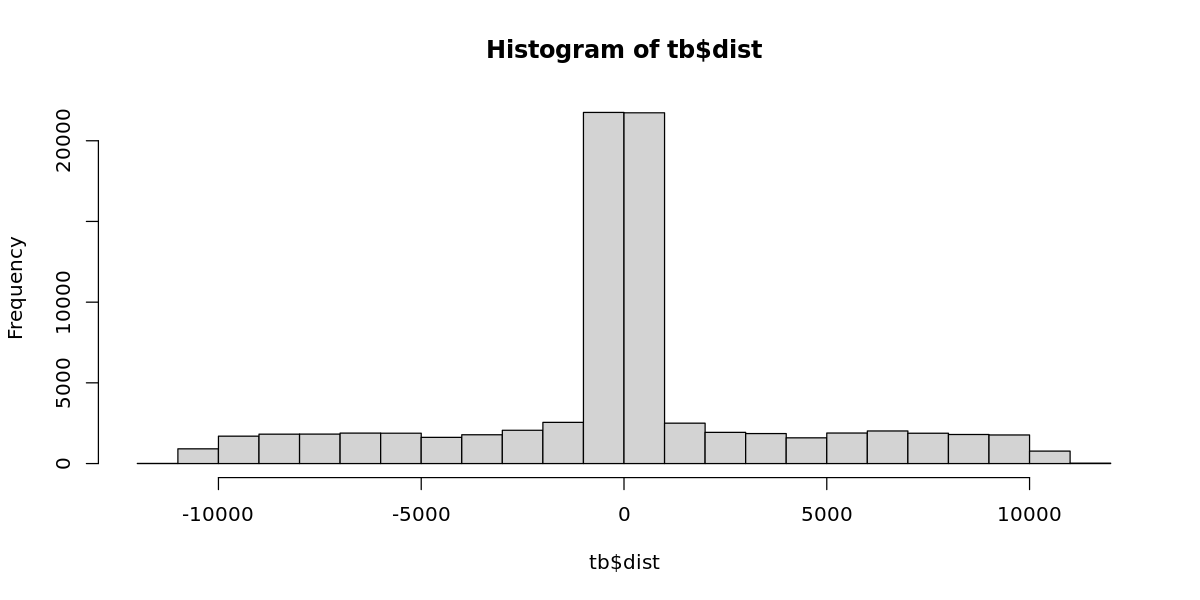

In [50]:
hist(tb$dist)

In [110]:
dist_gt = data.frame(
zero = rowSums(vtested==0),
one  =  rowSums(vtested==1),
two  = rowSums(vtested==2)
)

lba = apply(dist_gt[,1:3], 1,paste, collapse ="|")
lbb = apply(dist_gt[,3:1], 1,paste, collapse ="|")
#unicat = sapply(1:length(lba), function(x) max(as.numeric(lba[x]), as.numeric(lbb[x])))

unicat = sapply(1:length(lba), function(x) sort(c(lba[x], lbb[x]))[1])

In [112]:
longf$class= unicat[longf$varID]

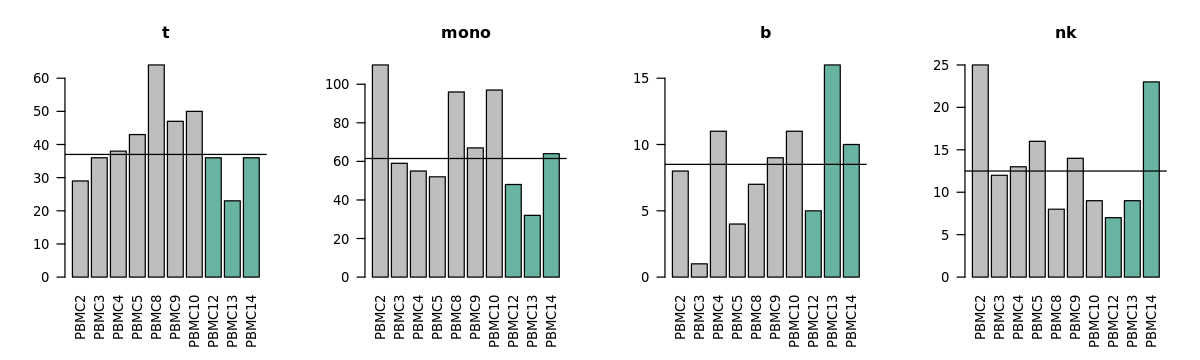

In [140]:
options(repr.plot.width=10, repr.plot.height=3)
par(mfrow=c(1,4))
for(c in c( "t", "mono", "b", "nk")){
        #   unique(longf$cell)[-c(1,2,4,6,9,15,16,18,17)])){
het2 = subset(longf, flag_fdr10==TRUE & exclude==FALSE & class=="0|2|8" & cell == c)

geno2 = subset(vtested, rownames(vtested) %in% het2$varID)
barplot(colSums(geno2==1), main =c, las=2, col =c(rep("gray", 7), rep("#69b3a2", 3)))
abline(h=median(colSums(geno2==1)))
}